In [2]:
using Plots,SparseArrays,Arpack, LaTeXStrings,LinearAlgebra

In [3]:
r,s,t = 1.0,0.5, -0.2 #(softer saddlepoint) #1.0,0.6, 0.1 # (softer minimum) # 

V(x) = r*sin(4π*x) + s*sin(2π*x) +t*cos(6π*x)
V′(x) = r*4π*cos(4π*x)+s*2π*cos(2π*x) - t*6π*sin(6π*x)
V′′(x) = -r*16π^2*sin(4π*x) - s*4π^2*r*sin(2π*x) - t*36π^2*cos(6π*x)

mu(x,β) = exp(-β*V(x))

plot(V,0,1,label="V")

N = 50000
Δx = 1/N
X = collect(range(0,1,N+1))
pop!(X)


@inline prev(i) = mod(i-1,1:N)
@inline next(i) = mod(i+1,1:N)


minima = [i for i=1:N if  V(X[prev(i)])>V(X[i])<V(X[next(i)])]
saddles = [i for i=1:N if V(X[prev(i)])<V(X[i])>V(X[next(i)])]

i0,i1 = minima
z0,z1 = saddles

ΔV₀₁ = min(V(X[z0])-V(X[i0]),V(X[z1])-V(X[i0]))
ΔV₁₀ = min(V(X[z0])-V(X[i1]),V(X[z1])-V(X[i1]))

killpoint = i1

lowest_saddle = (V(X[z0]) < V(X[z1])) ? z0 : z1
highest_saddle = (lowest_saddle == z0) ? z1 : z0

κ0 = -V′′(X[z0])
κ1 = -V′′(X[z1])

ℓ = min(κ0,κ1,V′′(X[i0]))
κ_high = -V′′(X[highest_saddle])
κ_low = -V′′(X[lowest_saddle])

V_high = V(X[highest_saddle])
V_low = V(X[lowest_saddle])

#Ωind = z0:z1 # bassin of i0
#Ωind = mod.(z1-N:z0,(1:N,)) # bassin of i1
# Ωind = [i for i=1:N if (X[z1]+0.1>X[i])&&(X[i]>X[z0]-0.1)] # domain encompassing bassin of i0
# Ω = X[Ωind]

println("--- Values of V ---")

println("\t--- Minima")
println("\t\t x0: ", V(X[i0]))
println("\t\t x1: ", V(X[i1]),"\n")

println("\t--- Saddles")
println("\t\t z0: ", V(X[z0]))
println("\t\t z1: ", V(X[z1]),"\n")

println("\t--- Potential barriers ---")
println("\t\t x0 → x1: ", ΔV₀₁)
println("\t\t x1 → x0: ", ΔV₁₀,"\n")


println("--- Values of V′′")

println("\t--- Minima")
println("\t\t x0: ", V′′(X[i0]))
println("\t\t x1: ", V′′(X[i1]),"\n")

println("\t--- Saddles")
println("\t\t z0: ", V′′(X[z0]))
println("\t\t z1: ", V′′(X[z1]))

βmax = 20 # empirical -- otherwise floating point errors become an issue
βrange = 0.1:0.1:βmax 

--- Values of V ---
	--- Minima
		 x0: -0.7883745185079865
		 x1: 

-1.2129367234671502

	--- Saddles
		 z0: 1.5474009682060923
		 z1: 0.6161946199241338

	--- Potential barriers ---
		 x0 → x1: 1.4045691384321204
		 x1 → x0: 1.8291313433912841

--- Values of V′′
	--- Minima
		 x0: 196.0528765457672
		 x1: 124.6655200815847

	--- Saddles
		 z0: -233.87348451775665
		 z1: -127.60176784722049


0.1:0.1:20.0

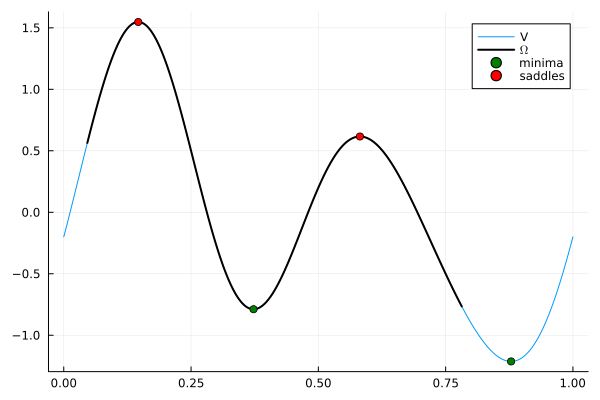

In [4]:
Ωind = [i for i=1:N if (X[z1]+0.2>X[i])&&(X[i]>X[z0]-0.1)]
Ω = X[Ωind]

plot(X,V.(X),label="V")
plot!(Ω,V.(Ω),color=:black,linewidth=2,label=L"\Omega")
scatter!(X[minima],V.(X[minima]),color=:green,label="minima")
scatter!(X[saddles],V.(X[saddles]),color=:red,label="saddles")

In [13]:
function eigenproblem(β,N,Ωind; witten=false)

    rate(i,j) = exp(-β*(V(X[j])-V(X[i]))/2)
    rate_witten(i,j) = exp(-β*(V(X[j])-V(X[i])))

    rows = vcat(([i,i,i] for i=1:N)...)
    cols = vcat(([i,prev(i),next(i)] for i=1:N)...)

    fac = N^2/β # scaling constant -- for consistent approximation of -L = ∇V⋅∇ - β⁻¹Δ

    # if !witten
    # else
    #     vals = vcat((fac*[rate(i,prev(i))+rate(i,next(i)),-rate_witten(i,prev(i)),-rate_witten(i,next(i))] for i=1:N)...) # exp(-βV/2)L exp(βV/2) -- appears numerically less stable for λ₂
    # end

    if !witten
        vals = vcat((fac*[rate(i,prev(i))+rate(i,next(i)),-rate(i,prev(i)),-rate(i,next(i))] for i=1:N)...)
    else
        vals = vcat((fac*[rate(i,prev(i))+rate(i,next(i)),-1,-1] for i=1:N)...)
    end

    L = sparse(rows,cols,vals)

    # if !witten
    # else
    #     λs,us = eigs(L[Ωind,Ωind],sigma=0,nev=3,which=:LR,tol=1e-22)
    # end
    
    λs,us = eigs(L[Ωind,Ωind],sigma=0,nev=4,which=:LR)


    λs = real.(λs)
    us = real.(us)

    return λs[1],λs[2],us[:,1],us[:,2],L , λs[3],us[:,3]
end

eigenproblem (generic function with 1 method)

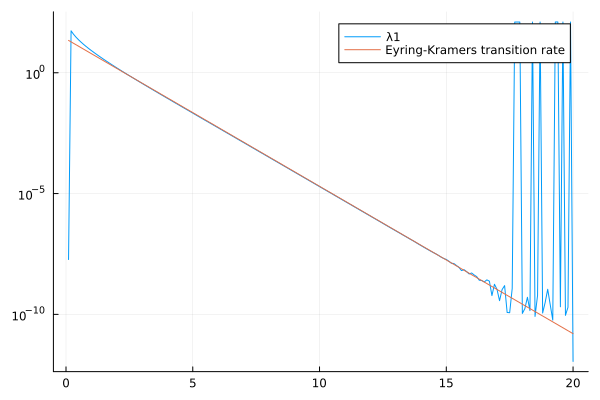

In [28]:
δ = 0.1 # δ = 0.1 ≡ proof in CKFS
h0(β) = (κ0*β/2)^(δ-1/2)
h1(β) = (κ1*β/2)^(δ-1/2)

Ω = X[Ωind]

λ1s = Float64[]
λ2s = Float64[]
λ3s = Float64[]

for β = βrange
    Ωind = [i for i=1:N if (X[z1]+h1(β)>X[i]>X[z0]-h0(β))]
    λ1,λ2,u1,u2,_,λ3,u3 = eigenproblem(β,N,Ωind;witten=true)
    push!(λ1s,λ1)
    push!(λ2s,λ2)
    push!(λ3s,λ3)
end

plot(βrange,λ1s,label="λ1",yaxis=:log)

dominant_prefactor = sqrt(abs(V′′(X[lowest_saddle]))*V′′(X[i0]))/2π # prefactor for transition (not exit) rate
plot!(β->dominant_prefactor*exp(-β*ΔV₀₁),label="Eyring-Kramers transition rate")


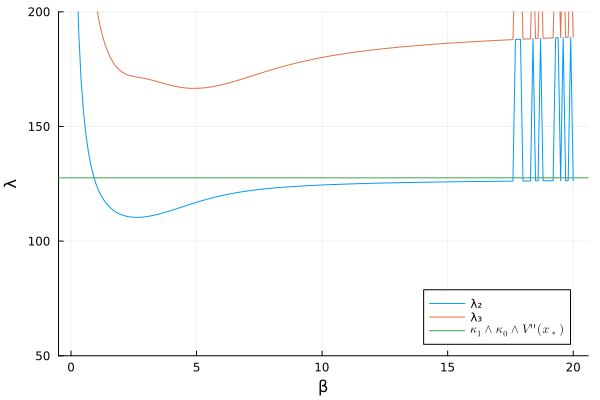

In [29]:
plot(βrange,λ2s,xlabel="β",ylabel="λ",label="λ₂")
plot!(βrange,λ3s,xlabel="β",ylabel="λ",label="λ₃")
hline!([ℓ],label=L"\kappa_1 \wedge \kappa_0 \wedge V''(x_*)")

ylims!(50,200)

h0(β) = 0.0007820447448211323
λ1 = 

1.6855946171618521e-13


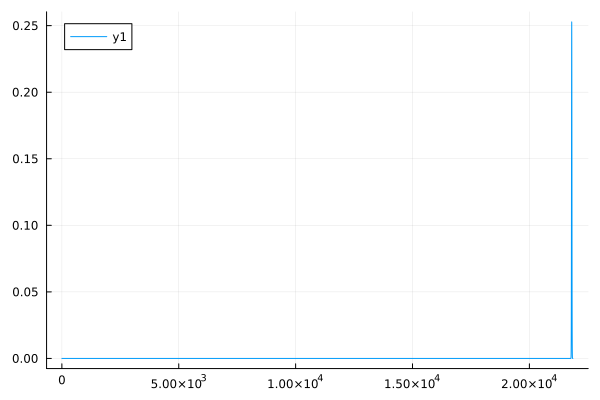

In [48]:
β = 500000.0
@show h0(β)
Ωind = [i for i=1:N if (X[z1]+h1(β)>X[i])&&(X[i]>X[z0]-h0(β))]
λ1,λ2,u1,u2,M,λ3,u3 = eigenproblem(β,N,Ωind;witten=true)
@show λ1
plot(u2)

In [20]:
length(Ωind) - z1+z0 -1

1231

In [11]:
λs,us = eigs(M[Ωind,Ωind],sigma=0,nev=10,which=:LR)
λs = real.(λs)
us = real.(us)

23003×10 Matrix{Float64}:
  6.37272e-20  -1.81669e-11  -2.2702e-8   …   4.24e-8     -5.64835e-10
 -2.74592e-19   8.08465e-11   1.00214e-7     -1.87113e-7   3.62323e-9
  2.6233e-19   -7.86546e-11  -9.28569e-8      1.7242e-7   -3.31346e-9
  1.52544e-19  -4.32994e-11  -5.38411e-8      1.00486e-7  -1.12608e-9
 -4.81162e-20   1.40167e-11   1.70035e-8     -3.17319e-8   1.41848e-9
  2.91335e-20  -7.96614e-12  -9.99651e-9  …   1.86292e-8   6.66721e-10
 -3.18738e-19   9.19822e-11   1.08782e-7     -2.02133e-7   5.55265e-9
  1.34874e-19  -3.77984e-11  -4.65955e-8      8.68967e-8  -2.4571e-10
 -3.19593e-19   9.48494e-11   1.10107e-7     -2.04162e-7   6.29195e-9
 -9.36105e-20   2.70539e-11   3.20378e-8     -5.95365e-8   2.97354e-9
  ⋮                                       ⋱               
  2.64235e-19   0.000492036  -8.96826e-8      1.68917e-7   0.00199308
 -3.18551e-19   0.000437334   1.14283e-7  …  -2.11914e-7   0.00177183
  2.45539e-19   0.000382643  -8.36291e-8      1.57304e-7   0.00155049
  4

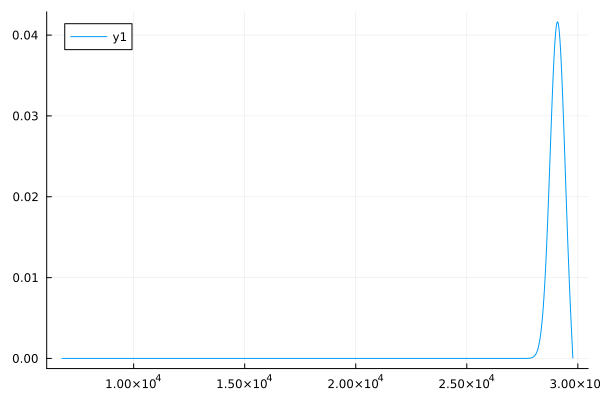

In [12]:
plot(Ωind,us[:,2])

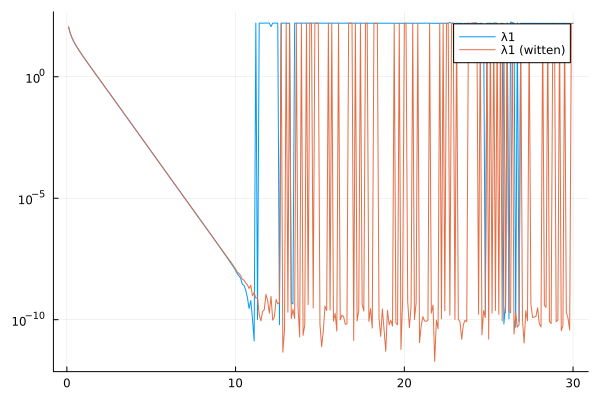

In [312]:

λ1s = Float64[]
λ1s_witten = Float64[]

Ωind = [i for i=1:N if (X[z1]+0.2>X[i])&&(X[i]>X[z0]-0.1)]

for β = βrange
    Ωind = [i for i=1:N if (X[z1]+h1(β)>X[i]>X[z0]-h0(β))]
    λ1,λ2,u1,u2,_,λ3,u3 = eigenproblem(β,N,Ωind;witten=false)
    push!(λ1s,λ1)
    λ1,λ2,u1,u2,_,λ3,u3 = eigenproblem(β,N,Ωind;witten=true)
    push!(λ1s_witten,λ1)

end

plot(βrange,λ1s,label="λ1",yaxis=:log)
plot!(βrange,λ1s_witten,label="λ1 (witten)")

In [289]:
Ω0 = z0:z1
Ωmax = [i for i=1:N if (X[z1]+0.1>X[i])&&(X[i]>X[z0]-0.1)]

plot(βrange,λ2s ,label="Numerical",xlabel=L"\beta",ylabel=L"\lambda_2")

λ3s_0 = Float64[]
λ3s_max = Float64[]

λ2s_0 = Float64[]
λ2s_max = Float64[]

λ1s_0 = Float64[]
λ1s_max = Float64[]

for β = βrange
    λ1,λ2,u1,u2,_,λ3,u3 = eigenproblem(β,N,Ω0)
    push!(λ3s_0,λ3)
    push!(λ2s_0,λ2)
    push!(λ1s_0,λ1)

    λ1,λ2,u1,u2,_,λ3,u3 = eigenproblem(β,N,Ωmax)
    push!(λ3s_max,λ3)
    push!(λ2s_max,λ2)
    push!(λ1s_max,λ1)
end



In [1]:
plot(βrange,λ2s_0,label="bassin",xlabel="β",ylabel="λ₂")
plot!(βrange,λ2s_max,label="large domain")

hline!([min(κ0,κ1,V′′(X[i0]))],label=L"\kappa_1 \wedge \kappa_0")
ylims!(50,200)

UndefVarError: UndefVarError: `plot` not defined

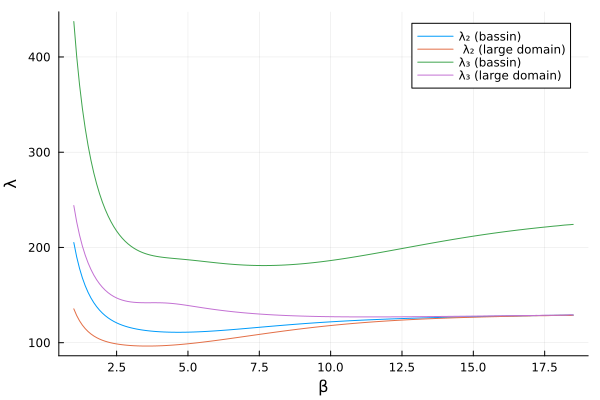

In [10]:
plot(βrange,λ2s_0,label="λ₂ (bassin)",xlabel="β",ylabel="λ")
plot!(βrange,λ2s_max,label=" λ₂ (large domain)")
plot!(βrange,λ3s_0,label="λ₃ (bassin)")
plot!(βrange,λ3s_max,label="λ₃ (large domain)")

In [23]:
    Ωind = z0:z1
    Ω=X[Ωind]
    
    anim_loc = @animate for β=βrange
        λ1,λ2,u1,u2 = eigenproblem(β,N,Ωind)
        mus = mu.(X,β)
        u2 /= sign(first(u2))

        # plot(Ω,u2,label="u₂ (β=$(round(β,digits=2)))")

         plot(u1[2:end]-u1[1:end-1],label="u₁' (β=$(round(β,digits=2)))")
        #plot!(Ω,u1,label="u1")
        plot!(twinx(),V,0,1,label="",color=:black)
    end

    mp4(anim_loc,"localization_saddlepoint.mp4")

┌ Info: Saved animation to /home/nblassel/Documents/QSDs.jl/experiments/discr/localization_saddlepoint.mp4
└ @ Plots /home/nblassel/.julia/packages/Plots/tDI0A/src/animation.jl:156


Plots.AnimatedGif("/home/nblassel/Documents/QSDs.jl/experiments/discr/localization_saddlepoint.mp4")

In [8]:
Ωind = [i for i=1:N if (X[z1]+0.1>X[i])&&(X[i]>X[z0]-0.1)]
Ω = X[Ωind]

anim_loc = @animate for β=βrange
    λ1,λ2,u1,u2 = eigenproblem(β,N,Ωind)
    #u1 /= sum(u1)*Δx2:end
    #u2 .*= mus[Ωind]
    u2 /= sum(abs,u2)*Δx
    u2 *= sign(u2[z1])

    plot(Ω,u1[2:end]-u1[1:end-1],label="u₂ (β=$(round(β,digits=2)))")
    #plot!(Ω,u1,label="u1")
    plot!(twinx(),V,0,1,label="",color=:black)
end

mp4(anim_loc,"localization_beyond_saddlepoint.mp4")

┌ Info: Saved animation to /home/nblassel/Documents/QSDs.jl/experiments/discr/localization_beyond_saddlepoint.mp4
└ @ Plots /home/nblassel/.julia/packages/Plots/tDI0A/src/animation.jl:156


Plots.AnimatedGif("/home/nblassel/Documents/QSDs.jl/experiments/discr/localization_beyond_saddlepoint.mp4")

In [9]:
anim_quasi = @animate for β=βrange
    λ1,λ2,u1,u2 = eigenproblem(β,N,Ωind)

    u2 /= u2[z1-first(Ωind)+1]

    κ = -V′′(X[lowest_saddle])
    fit(x) = exp(-β*κ*(x-X[lowest_saddle])^2/2)

    plot(Ω,u2,label=L"u_2 (\beta=%$β")
    plot!(Ω,fit.(Ω),label="Ansatz gaussien")
end

mp4(anim_quasi,"quasimode.mp4")

┌ Info: Saved animation to /home/nblassel/Documents/QSDs.jl/experiments/discr/quasimode.mp4
└ @ Plots /home/nblassel/.julia/packages/Plots/tDI0A/src/animation.jl:156


Plots.AnimatedGif("/home/nblassel/Documents/QSDs.jl/experiments/discr/quasimode.mp4")

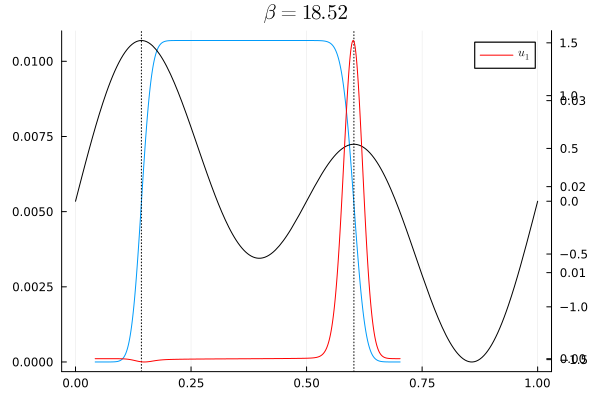

In [16]:
Ωind = [i for i=1:N if (X[z1]+0.1>X[i])&&(X[i]>X[z0]-0.1)]
Ω = X[Ωind]


λ1,λ2,v1,v2 = eigenproblem(βmax,N,Ωind;witten=true)
v1 /= sign(sum(v1))

λ1,λ2,u1,u2 = eigenproblem(βmax,N,Ωind;witten=false)
u1 /= sign(sum(u1))
plot(Ω,u1,label=L"u_1")

plot!(twinx(),V,0,1,label="",color=:black)
plot!(twinx(),Ω,u2,label=L"u_1",title=L"\beta=%$βmax",color=:red)
vline!(X[saddles],label="",color=:black,linestyle=:dot)

In [ ]:
Ωind = [i for i=1:N if (X[z1]+0.1>X[i])&&(X[i]>X[z0]-0.1)]
Ω = X[Ωind]
β = 13

λ1,λ2,v1,v2 = eigenproblem(β,N,Ωind;witten=true)
v2 /= sign(sum(v2))
plot(Ω,v2,label="v₂",title=L"\beta=%$β")

λ1,λ2,u1,u2 = eigenproblem( β,N,Ωind;witten=false)
u2 /= sign(sum(u2))
plot!(Ω,u2,label=L"u_2")

plot!(twinx(),V,0,1,label="",color=:black)
vline!(X[saddles],label="",color=:black,linestyle=:dot)

In [ ]:
errs = Float64[]

anim_du1 = @animate for β=βrange
    λ1,λ2,u1,u2 = eigenproblem( β,N,Ωind;witten=false)
    u1 *= sign(u1[z1 - first(Ωind)+1])
    du = u1[2:end] - u1[1:end-1]
    plot(Ω[2:end],du,label=L"u_1′")
    plot!(twinx(),V,0,1,color=:black,label="")
    vline!(X[saddles],label="",color=:black,linestyle=:dot)
    α = 0.5

    fit(x) = -α*sqrt(β*κ_high)*exp(-β*κ_high*(x-X[highest_saddle])^2/2) + (1-α)*sqrt(β*κ_low)*exp(-β*κ_low*(x-X[lowest_saddle])^2/2) #sum of two gaussians
    fit_vec = fit.(Ω[1:end-1])
    fit_vec *= du[z1 - first(Ωind)+1]/fit_vec[z1-first(Ωind)+1]
    plot!(Ω[1:end-1],fit_vec,label="Gaussian guess")

    w = @. exp(-β*V(Ω[1:end-1]))

    rel_error = sqrt(sum(@. w*(fit_vec-du)^2))/sqrt(sum(@. w*du^2))
    push!(errs,rel_error)
end

mp4(anim_du1,"du1_guess.mp4")

In [ ]:
plot(βrange,errs,xlabel=L"\beta",ylabel=L"Relative $L^2_\mu(\Omega)$ error",xaxis=:log,yaxis=:log,label="Numerical",ylims=(0.05,1.1maximum(errs)))

In [ ]:

    
    errs = Float64[]
    for β=βrange
        fit(x) = sqrt(β*κ_high)*exp(-β*κ_high*(x-X[highest_saddle])^2/2) - sqrt(β*κ_low)*exp(-β*κ_low*(x-X[lowest_saddle])^2/2)
        λ1,λ2,u1,u2,M = eigenproblem(β,N,Ωind;witten=false)
        du1_tilde = fit.(Ω[2:end-1])
        u1_tilde = cumsum(du1_tilde)
        push!(u1_tilde,0)
        pushfirst!(u1_tilde,0)

        w = @. exp(-β*V(Ω))
        err = sqrt(sum( w.*(M[Ωind,Ωind]*u1_tilde - λ1*u1_tilde).^2))/sqrt(sum(w.*u1_tilde.^2))
        push!(errs,err)
    end


In [ ]:

scatter(βrange,errs,yaxis=:log,xlabel="β",ylabel="Relative error",label=L"\frac{\|(-L_\beta-\lambda_1)\widetilde{u}_{1,\beta}\|_{L^2_w}}{\|\widetilde{u}_{1,\beta}\|_{L^2_w}}",markershape=:vline)
plot!(βrange,errs,label="")

In [ ]:
β=10
λ1,λ2,u1,u2,M = eigenproblem(β,N,Ωind;witten=false)
#plot(Ω,u1)
w_witten = @. exp(β*V(Ω)/2)
v1_tilde = u1 .* w_witten
plot(Ω,u1 .* w_witten)
λ1,λ2,v1,v2,M = eigenproblem(β,N,Ωind;witten=true)
v1 *= v1_tilde[z0-first(Ωind)+1]/v1[z0-first(Ωind)+1]
plot!(Ω,v1)
plot!(twinx(),V,0,1)
vline!([X[i0]])

In [ ]:
heights_high = Float64[]

for β=βrange
    λ1,λ2,u1,u2,M = eigenproblem(β,N,Ωind)
    u2 /= u2[lowest_saddle - first(Ωind)+1]
    push!(heights_high,-u2[highest_saddle-first(Ωind)+1])
end

In [ ]:
scatter(βrange,abs.(heights_high),yaxis=:log)

In [ ]:
V(X[highest_saddle])-V(X[lowest_saddle])
indβ=[i for (i,β)=enumerate(βrange) if 13<β<14]

x = log.(βvec[indβ])
y = log.(heights_high[indβ])
x .-= first(X)
y .-=first(Y)


βvec= collect(βrange)
scatter(βvec[indβ],heights_high[indβ],yaxis=:log)


target = x\y
@show target

qs = [κ_high,κ_low,V(X[highest_saddle]),V(X[lowest_saddle])]
diffs = [a-b for a=qs,b=qs]
ratios = [a/b for a=qs,b=qs]

display(diffs)
display(ratios)


In [ ]:
using Optim

β = 7.0

fac = N^2/β

Ωind = [i for i=1:N if i!=i1]
Ω = Ωind
λ1,λ2,u1,u2,M = eigenproblem(β,N,Ωind)

grad_mask = [i for (i,x)=enumerate(X) if abs(x-X[i0])< 0.05] # zero killing rate deep in the well
update_ixs = setdiff(Ωind,grad_mask)

function fg!(F,G,x)
    A = spzeros(N,N)
    alpha = exp.(x)
    A[update_ixs,update_ixs] .= alpha

    L = (M+A)[Ωind,Ωind]

    λs,us = eigs(L,sigma=0,nev=2,which=:LR,tol=1e-22)
    _,vs = eigs(L',sigma=0,nev=2,which=:LR,tol=1e-22) # left eigenvectors

    λ1,λ2 = real.(λs)
    u1,u2 = eachcol(real.(us))
    v1,v2 = eachcol(real.(vs))

    ∂λ1 = (v1 .* u1)/(v1'u1)
    ∂λ2 = (v2 .* u2)/(v2'u2)

    grad = zeros(N)


    if G !== nothing
        #∂ₓλ = ∂ₓa ∂ₐλ = a .* ∂ₐλ
        grad[Ωind] .= ∂λ1/λ1 - ∂λ2/λ2
        G .= alpha .* grad[update_ixs]
    end

    if F!==nothing
        return log(λ1) - log(λ2)
    end
end

x0 = -ones(length(update_ixs))
lower = fill(-10,length(x0))
upper = fill(10,length(x0))
results = optimize(Optim.only_fg!(fg!),lower,upper,x0,Fminbox(Optim.LBFGS()),Optim.Options(show_trace=true,show_every=100))

